**Introducing BESS**

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [68]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

In [69]:
os.chdir('/home/MA')

In [70]:
power_balance = pd.read_pickle('Calculations/Hawaii/power_balance_hawaii.pkl')

Define battery size

In [71]:
battery_size = 6

In [72]:
max_c_charge = 0.25
max_c_discharge = 0.5

Roundtrip efficiency solar battery: 85% (check alternative sources) https://www.homerenergy.com/products/pro/docs/latest/battery_roundtrip_efficiency.html#:~:text=The%20battery%20round%2Dtrip%20efficiency,Typically%20it%20is%20about%2080%25.
Assumption: Losses occur during discharging only (Charging efficiency is 99% https://www.powertechsystems.eu/home/tech-corner/lithium-ion-battery-advantages/)

In [73]:
eta_discharge = 0.85

Define function for battery dispatch

In [74]:
from Battery_dispatch_function import BatteryDispatch

In [75]:
power_balance = BatteryDispatch(power_balance, battery_size, eta_discharge, max_c_charge, max_c_discharge)

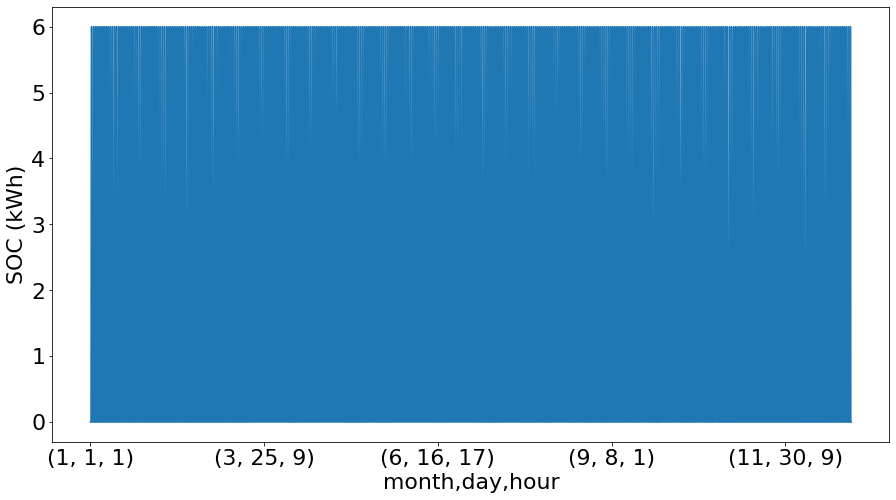

In [76]:
power_balance['SoC'].plot(ylabel = 'SOC (kWh)'); 

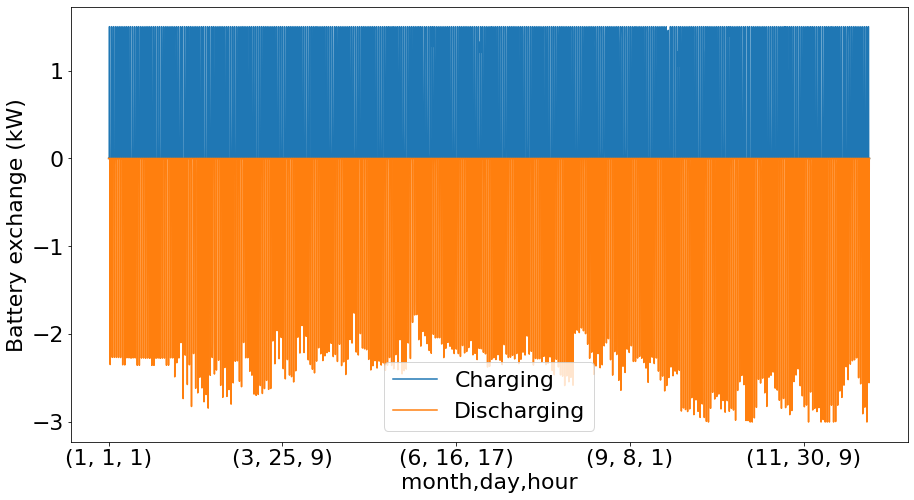

In [77]:
power_balance[['Charging', 'Discharging']].plot(ylabel = 'Battery exchange (kW)'); 

In [78]:
sum(power_balance['Charging'])

2189.999999999999

In [79]:
sum(power_balance['Discharging'])

-1861.5000000000005

Check how many cycles were carried out

In [80]:
sum(power_balance['Charging'])/battery_size

364.99999999999983

In [81]:
power_balance['exchange grid new'] = power_balance['to Grid New'] - power_balance['from Grid New']

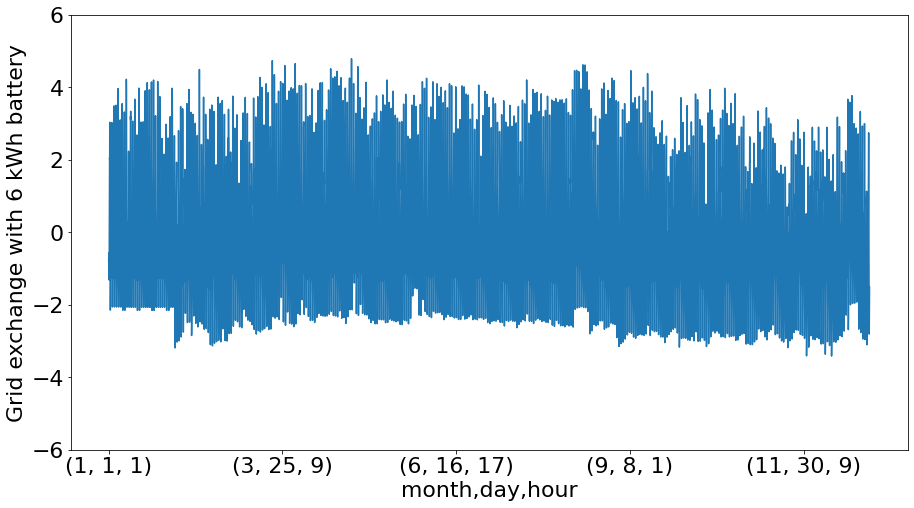

In [82]:
power_balance['exchange grid new'].plot(ylabel = 'Grid exchange with 6 kWh battery', ylim = ([-6, 6]));

Self-consumption share with BESS

In [83]:
sum(power_balance['consumption'] - power_balance['from Grid New'])/sum(power_balance['from PV'])

0.6198466978788005

Curtailment calculation with BESS

In [84]:
sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

0.35544165605100786

PV share with BESS

In [85]:
1-sum(power_balance['from Grid New'])/sum(power_balance['consumption'])

0.5692602621267895

Losses in the battery system

In [86]:
(sum(power_balance['Charging']) + sum(power_balance['Discharging']))/sum(power_balance['from PV'])

0.024711646070189216

Reduced consumption from grid:
also mention PV reduction, check with curtailment!

In [87]:
grid_savings = sum(power_balance['Discharging'])
grid_savings

-1861.5000000000005

**CO$_2$ calculations**

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [89]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot

In [90]:
os.chdir('/home/MA')

In [91]:
PV_lifetime = 25 #years

In [92]:
power_balance = pd.read_pickle('Calculations/Hawaii/power_balance_hawaii.pkl')

In [93]:
battery_lifetime = 15 # years

Grid emissions for Hawaii from https://www.eia.gov/electricity/state/hawaii/ 
Converted from lbs/MWh to g/kWh

In [94]:
grid_emissions_hawaii= 751.148965 # g CO2/kWh

In [95]:
elec_battery_prod = 95.5 # kwh_el/kWh_n

Assumption: Battery production in China
at 637 g CO2/kWh
https://www.mdpi.com/1996-1073/14/4/961/pdf

In [96]:
CO2_intensity_China = 637

In [97]:
electricity_PV_production = 1597 # kWh_el kWp-1

In [98]:
PV_size = 6 #kW_p

### CO2 savings of PV only

Yearly energy self consumed, therefore reduced consumption from grid

In [99]:
self_consumption_kWh = sum(power_balance['consumption'] - power_balance['from Grid'])

In [100]:
total_CO2_PV_prod = electricity_PV_production * PV_size * CO2_intensity_China

In [102]:
reduced_CO2_PV_g = grid_emissions_hawaii * self_consumption_kWh * PV_lifetime - total_CO2_PV_prod

In [103]:
reduced_CO2_PV_t = reduced_CO2_PV_g/1000000

In [104]:
reduced_CO2_PV_t

113.67307244588521

### CO2 savings of added batteries

In [105]:
battery_size = [0, 6, 12, 18, 24, 72]
results = pd.DataFrame()
results['battery_size'] = battery_size
results['curtailment'] = ''
results['yearly_savings_kWh'] = ''

In [106]:
for i in range(0, len(results['battery_size'])):
    powerbalance = BatteryDispatch(power_balance, results['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
    results['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
    results['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

In [107]:
results['total_savings_kWh'] = results['yearly_savings_kWh'] * PV_lifetime

The yearly CO2 savings by grid consumption reduction in tons amount to:

In [108]:
results['yearly_savings_CO2'] = results['yearly_savings_kWh'] * grid_emissions_hawaii / 1000000

For a PV lifetime of 25 years, this corresponds to a gross saving of 

In [109]:
results['total_CO2_grid_reduced'] = results['yearly_savings_CO2'] * PV_lifetime

Caclculate total battery energy intensity by accounting for dead capacity (20%) which is not used when cycling to improve performance, and for a replacement after 15 years (battery lifetime)

In [110]:
results['total_elec_battery_prod'] = 2 * (elec_battery_prod * results['battery_size']/0.8)

Net saving of battery deployment

In [111]:
results['total_CO2_battery_prod'] = results['total_elec_battery_prod'] * CO2_intensity_China / 1000000

In [112]:
results['net_CO2_savings'] = results['total_CO2_grid_reduced'] - results['total_CO2_battery_prod'] 

In [113]:
results['stored'] = results.iloc[0]['curtailment'] - results['curtailment']

In [114]:
results

,battery_size,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored
0,0,0.520186,-0,-0,-0,-0,0.0,0.000000,-0,0
1,6,0.355442,1861.5,46537.5,1.39826,34.9566,1432.5,0.912502,34.0441,0.164744
2,12,0.193957,3686.17,92154.2,2.76886,69.2215,2865.0,1.825005,67.3965,0.326229
3,18,0.0585637,5216.02,130401,3.91801,97.9502,4297.5,2.737507,95.2127,0.461622
4,24,0.00998614,5764.92,144123,4.33031,108.258,5730.0,3.650010,104.608,0.5102
5,72,0,5877.75,146944,4.41507,110.377,17190.0,10.950030,99.4267,0.520186


In [115]:
results.set_index("battery_size",drop=True,inplace=True)

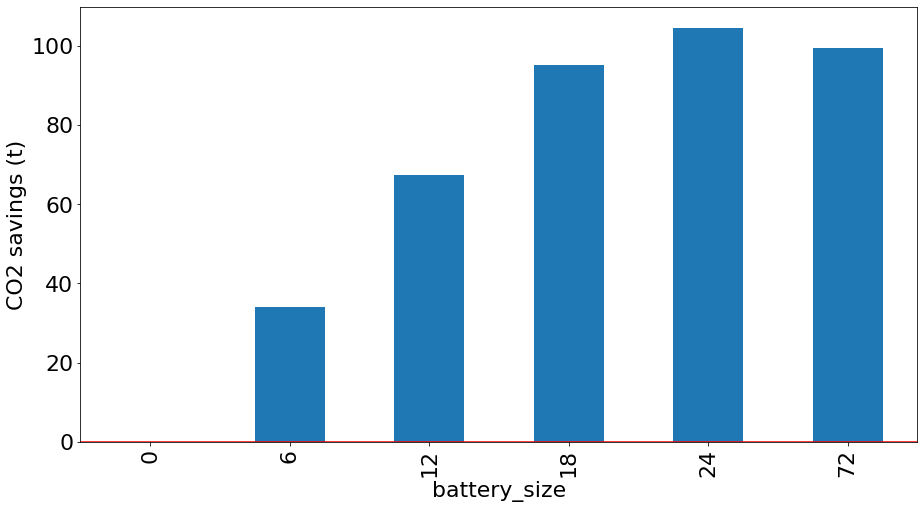

In [116]:
results['net_CO2_savings'].plot.bar(ylabel ='CO2 savings (t)');
plt.axhline(y=0, color='r', linestyle='-')

In [117]:
results['net_CO2_savings_with_PV'] = results['net_CO2_savings'] + reduced_CO2_PV_t

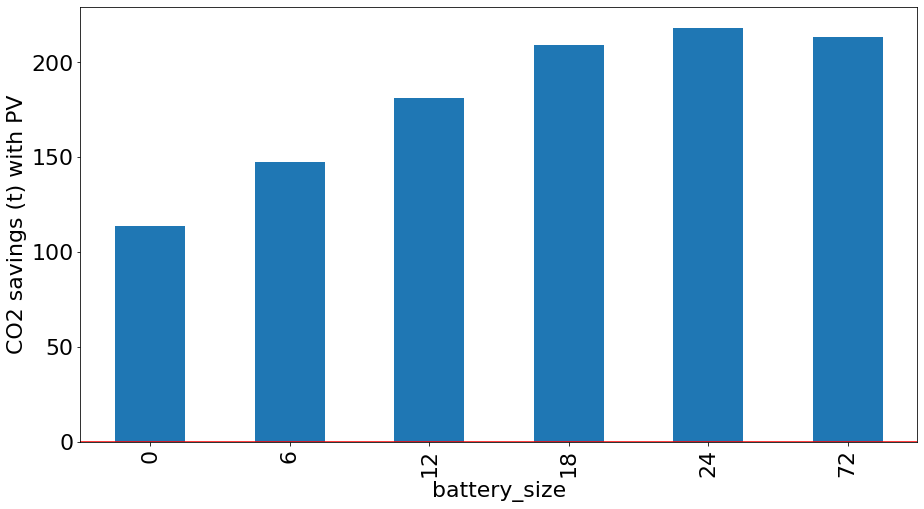

In [118]:
results['net_CO2_savings_with_PV'].plot.bar(ylabel ='CO2 savings (t) with PV');
plt.axhline(y=0, color='r', linestyle='-')

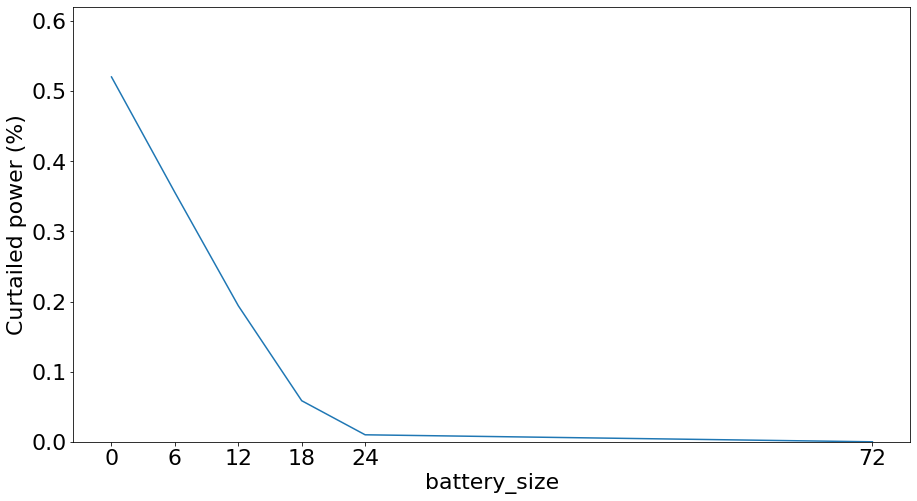

In [119]:
results['curtailment'].plot(xticks = battery_size, ylabel = 'Curtailed power (%)', ylim = ([0, 0.62]));

## EROI calculations

Electricity intensity used for PV production

In [120]:
PV_production_hourly = pd.read_pickle('Calculations/Hawaii/PV_production_Hawaii.pkl')

In [121]:
yearly_PV_production = sum(PV_production_hourly)

In [122]:
results['total_elec_PV_prod'] = electricity_PV_production * PV_size

In [123]:
results['ESOI'] = results['total_savings_kWh'].div(results['total_elec_battery_prod'].where(results['total_elec_battery_prod'] != 0, np.nan))

In [124]:
results['EROI_gen'] = yearly_PV_production*PV_lifetime/results['total_elec_PV_prod']

**Firstly, calculate the EROI for the case where electricity can be made usful through the distribution grid:**

In [125]:
results['EROI_grid_useful'] = results['EROI_gen']

**Now, let's consider the case where power is curtailed unless stored for later use**

In [126]:
results['EROI_grid_curtailed'] = (1 - results['stored'] + eta_discharge * results['stored'])/(1/results['EROI_gen']+results['stored']/results['ESOI'])*(1-results['curtailment'])

In [127]:
results['EROI_grid_curtailed'] = results['EROI_grid_curtailed'].fillna(results['EROI_gen']*(1-results['curtailment']))

In [128]:
results['ESOI'] = results['ESOI'].fillna(0)

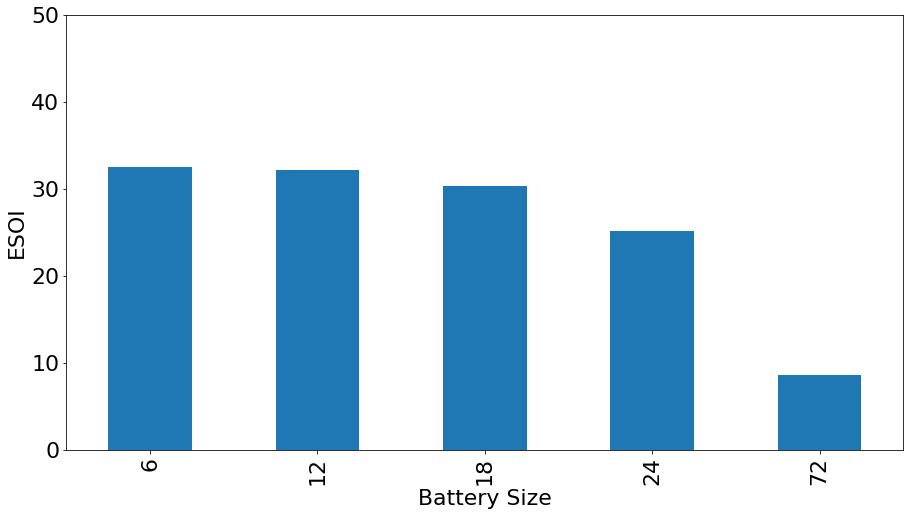

In [129]:
results.ESOI[results['ESOI']!=0].plot.bar(xlabel = 'Battery Size', ylabel = 'ESOI', ylim = ([0, 50]));

In [130]:
results

,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored,net_CO2_savings_with_PV,total_elec_PV_prod,ESOI,EROI_gen,EROI_grid_useful,EROI_grid_curtailed
battery_size,,,,,,,,,,,,,,,
0,0.520186,-0,-0,-0,-0,0.0,0.000000,-0,0,113.673,9582,0.000000,34.683071,34.683071,16.641424
6,0.355442,1861.5,46537.5,1.39826,34.9566,1432.5,0.912502,34.0441,0.164744,147.717,9582,32.486911,34.683071,34.683071,18.541691
12,0.193957,3686.17,92154.2,2.76886,69.2215,2865.0,1.825005,67.3965,0.326229,181.07,9582,32.165508,34.683071,34.683071,19.669160
18,0.0585637,5216.02,130401,3.91801,97.9502,4297.5,2.737507,95.2127,0.461622,208.886,9582,30.343349,34.683071,34.683071,19.894020
24,0.00998614,5764.92,144123,4.33031,108.258,5730.0,3.650010,104.608,0.5102,218.281,9582,25.152335,34.683071,34.683071,18.613717
72,0,5877.75,146944,4.41507,110.377,17190.0,10.950030,99.4267,0.520186,213.1,9582,8.548214,34.683071,34.683071,10.280036


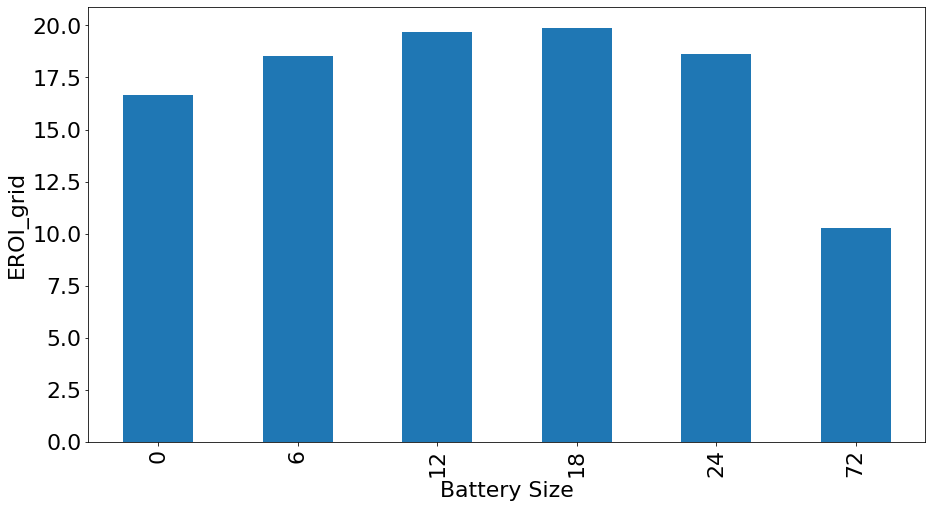

In [131]:
results['EROI_grid_curtailed'].plot.bar(xlabel = 'Battery Size', ylabel = 'EROI_grid');